# AQI Prediction Pipeline (48-hour Forecast)

This notebook implements a robust pipeline for predicting AQI (ISPU) for the next 48 hours using XGBoost and recursive forecasting.

## Key Improvements:
- **Feature Engineering**: Manual lags and rolling statistics.
- **Regularization**: XGBoost parameters tuned to prevent overfitting.
- **Recursive Forecasting**: Iterative prediction for multi-step forecasting.
- **Pipeline**: Modular structure for easier deployment.

In [44]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set plot style
sns.set(style="whitegrid")

In [45]:
# pip install xgboost

## 1. Feature Engineering Setup

In [46]:
# Lag and rolling window configuration without classes
lags = [1, 2, 3, 6, 12, 24]
rolls = [3, 6, 12, 24]

## 2. Load and Preprocess Data

In [47]:
raw = pd.read_csv("data_aqi.csv")

rename_map = {
    "Timestamp": "timestamp",
    "PM2.5 density": "pm25_density",
    "Air quality level": "air_quality_level",
    "PM10 density": "pm10_density"
}
if "PM2.5 density" in raw.columns:
    raw = raw.rename(columns=rename_map)

raw["timestamp"] = pd.to_datetime(raw["timestamp"])
raw = raw.sort_values("timestamp").set_index("timestamp")

In [48]:
raw

,No,PM2.5 raw,pm25_density,pm10_density,air_quality_level,Temperature,Humidity,Pressure,Altitude estimate,Device ID
timestamp,,,,,,,,,,
2025-12-05 22:00:00,1,1.3,1.5,2.9,BAIK,25.4,80.1,940.0,628.8,10:B4:1D:E8:2E:E4
2025-12-05 22:00:30,2,0.5,1.0,2.0,BAIK,24.1,85.0,940.3,626.5,10:B4:1D:E8:2E:E4
2025-12-05 22:01:00,3,5.5,7.6,11.3,BAIK,25.3,84.6,940.7,623.1,10:B4:1D:E8:2E:E4
2025-12-05 22:01:30,4,1.1,1.9,4.4,BAIK,24.4,83.1,938.9,630.0,10:B4:1D:E8:2E:E4
2025-12-05 22:02:00,5,4.0,4.3,6.5,BAIK,27.4,78.5,939.4,630.0,10:B4:1D:E8:2E:E4
...,...,...,...,...,...,...,...,...,...,...
2026-01-09 15:17:30,99996,0.8,1.2,2.2,BAIK,29.9,72.3,940.7,623.4,10:B4:1D:E8:2E:E4
2026-01-09 15:18:00,99997,0.5,1.0,2.0,BAIK,27.9,73.5,940.4,626.2,10:B4:1D:E8:2E:E4
2026-01-09 15:18:30,99998,3.7,4.1,7.1,BAIK,30.3,68.8,941.5,620.0,10:B4:1D:E8:2E:E4


In [49]:
if "aqi_ispu" not in raw.columns:
    x_points = np.array([0.0, 50, 150, 350, 420, 10000])
    y_points = np.array([0, 50, 100, 200, 300, 500])
    raw["aqi_ispu"] = np.interp(raw["pm10_density"], x_points, y_points)

# Keep ONLY pm10_density and aqi_ispu columns
df = raw[["pm10_density", "aqi_ispu"]].resample("1h").mean().ffill()

print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (834, 2)


C:\Users\user\AppData\Local\Temp\ipykernel_35508\3239792161.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = raw[["pm10_density", "aqi_ispu"]].resample("1H").mean().ffill()


,pm10_density,aqi_ispu
timestamp,,
2025-12-05 22:00:00,30.995000,25.464583
2025-12-05 23:00:00,32.145833,26.506732
2025-12-06 00:00:00,23.521667,19.666667
2025-12-06 01:00:00,31.164167,23.546250
2025-12-06 02:00:00,30.674167,23.363036


In [50]:
a = df.copy()
for l in lags:
    a[f"aqi_lag_{l}"] = a["aqi_ispu"].shift(l)
    a[f"pm10_lag_{l}"] = a["pm10_density"].shift(l)

for r in rolls:
    a[f"aqi_roll_mean_{r}"] = a["aqi_ispu"].rolling(r).mean()
    a[f"aqi_roll_std_{r}"] = a["aqi_ispu"].rolling(r).std()

In [51]:
a

,pm10_density,aqi_ispu,aqi_lag_1,pm25_lag_1,aqi_lag_2,pm25_lag_2,aqi_lag_3,pm25_lag_3,aqi_lag_6,pm25_lag_6,...,aqi_lag_24,pm25_lag_24,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-05 22:00:00,30.995000,25.464583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05 23:00:00,32.145833,26.506732,25.464583,30.995000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00,23.521667,19.666667,26.506732,32.145833,25.464583,30.995000,NaN,NaN,NaN,NaN,...,NaN,NaN,23.879327,3.685295,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 01:00:00,31.164167,23.546250,19.666667,23.521667,26.506732,32.145833,25.464583,30.995000,NaN,NaN,...,NaN,NaN,23.239883,3.430309,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 02:00:00,30.674167,23.363036,23.546250,31.164167,19.666667,23.521667,26.506732,32.145833,NaN,NaN,...,NaN,NaN,22.191984,2.188907,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 11:00:00,67.453333,46.315511,40.426153,50.614167,58.670280,87.175833,55.201354,76.795833,30.386657,39.703333,...,46.573371,65.427500,48.470648,9.311042,50.108776,7.507303,39.501983,12.287330,41.764388,11.574656
2026-01-09 12:00:00,54.466667,42.237293,46.315511,67.453333,40.426153,50.614167,58.670280,87.175833,43.920238,59.846667,...,40.126717,53.062500,42.992986,3.016528,49.828285,7.810098,40.679049,11.762418,41.852329,11.569689
2026-01-09 13:00:00,61.611667,43.173210,42.237293,54.466667,46.315511,67.453333,40.426153,50.614167,56.119120,83.476667,...,37.339518,50.276667,43.908672,2.136269,47.670634,7.506941,41.550914,11.502986,42.095400,11.531975


In [52]:
feature_df = df.copy()
feature_df["hour"] = feature_df.index.hour
feature_df["dayofweek"] = feature_df.index.dayofweek
feature_df["month"] = feature_df.index.month
feature_df["weekofyear"] = feature_df.index.isocalendar().week.astype(int)
feature_df["dayofyear"] = feature_df.index.dayofyear

# Display the updated feature_df with new columns
print("Feature DataFrame with new time-based features:")
feature_df.head()

Feature DataFrame with new time-based features:


,pm10_density,aqi_ispu,hour,dayofweek,month,weekofyear,dayofyear
timestamp,,,,,,,
2025-12-05 22:00:00,30.995000,25.464583,22,4,12,49,339
2025-12-05 23:00:00,32.145833,26.506732,23,4,12,49,339
2025-12-06 00:00:00,23.521667,19.666667,0,5,12,49,340
2025-12-06 01:00:00,31.164167,23.546250,1,5,12,49,340
2025-12-06 02:00:00,30.674167,23.363036,2,5,12,49,340


In [53]:
lags = [1, 2, 3, 6, 12, 24, 48]
rolls = [3, 6, 12, 24, 48]

for l in lags:
    feature_df[f"aqi_lag_{l}"] = feature_df["aqi_ispu"].shift(l)
    feature_df[f"pm10_lag_{l}"] = feature_df["pm10_density"].shift(l)

for r in rolls:
    feature_df[f"aqi_roll_mean_{r}"] = feature_df["aqi_ispu"].rolling(r).mean()
    feature_df[f"aqi_roll_std_{r}"] = feature_df["aqi_ispu"].rolling(r).std()

print("Feature engineering with new lags and rolling windows applied.")
feature_df.head()

Feature engineering with new lags and rolling windows applied.


,pm10_density,aqi_ispu,hour,dayofweek,month,weekofyear,dayofyear,aqi_lag_1,pm10_lag_1,aqi_lag_2,...,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24,aqi_roll_mean_48,aqi_roll_std_48
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-05 22:00:00,30.995000,25.464583,22,4,12,49,339,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05 23:00:00,32.145833,26.506732,23,4,12,49,339,25.464583,30.995000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00,23.521667,19.666667,0,5,12,49,340,26.506732,32.145833,25.464583,...,23.879327,3.685295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 01:00:00,31.164167,23.546250,1,5,12,49,340,19.666667,23.521667,26.506732,...,23.239883,3.430309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 02:00:00,30.674167,23.363036,2,5,12,49,340,23.546250,31.164167,19.666667,...,22.191984,2.188907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
feature_df = feature_df.dropna()

features = [c for c in feature_df.columns if c not in ["aqi_ispu", "pm10_density"]]
target = feature_df["aqi_ispu"]

print("Features and target defined. Shape of feature_df after dropping NaNs:", feature_df.shape)
print("Number of features:", len(features))


Features and target defined. Shape of feature_df after dropping NaNs: (786, 31)
Number of features: 29


## 3. Training with Regularization

Mulai Training dengan Time Series Cross-Validation...


Fold 1 | RMSE: 4.6222 | MAE: 3.7709 | R2: 0.8133
Fold 2 | RMSE: 2.8414 | MAE: 2.1710 | R2: 0.9293
Fold 3 | RMSE: 3.4335 | MAE: 2.5021 | R2: 0.9010
Fold 4 | RMSE: 2.9168 | MAE: 2.2178 | R2: 0.9263
Fold 5 | RMSE: 2.2983 | MAE: 1.8357 | R2: 0.9525

=== Rata-rata Performa Validasi ===
Avg RMSE : 3.2224
Avg MAE  : 2.4995
Avg R2   : 0.9045

Melatih Model Final untuk Disimpan...
[0]	validation_0-rmse:10.69360	validation_1-rmse:11.22035
[100]	validation_0-rmse:5.67539	validation_1-rmse:5.94714
[200]	validation_0-rmse:3.82029	validation_1-rmse:4.13785
[300]	validation_0-rmse:2.95847	validation_1-rmse:3.42151
[400]	validation_0-rmse:2.48020	validation_1-rmse:3.03488
[500]	validation_0-rmse:2.17176	validation_1-rmse:2.83603
[600]	validation_0-rmse:1.92014	validation_1-rmse:2.68974
[700]	validation_0-rmse:1.73281	validation_1-rmse:2.60401
[800]	validation_0-rmse:1.57491	validation_1-rmse:2.53883
[900]	validation_0-rmse:1.44059	validation_1-rmse:2.48180
[1000]	validation_0-rmse:1.32340	validation_1

<Figure size 1000x600 with 0 Axes>

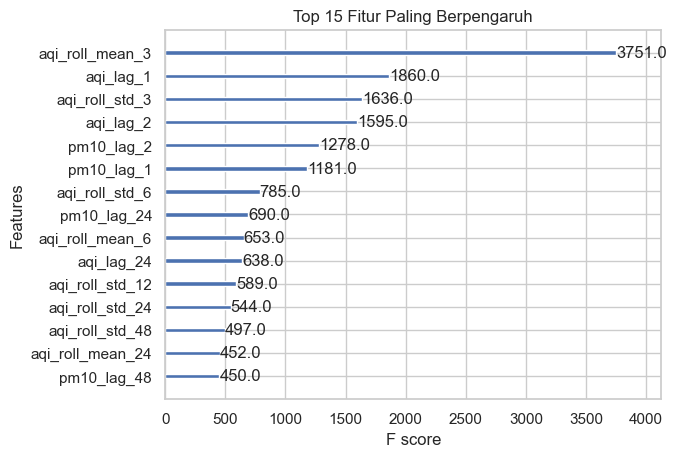

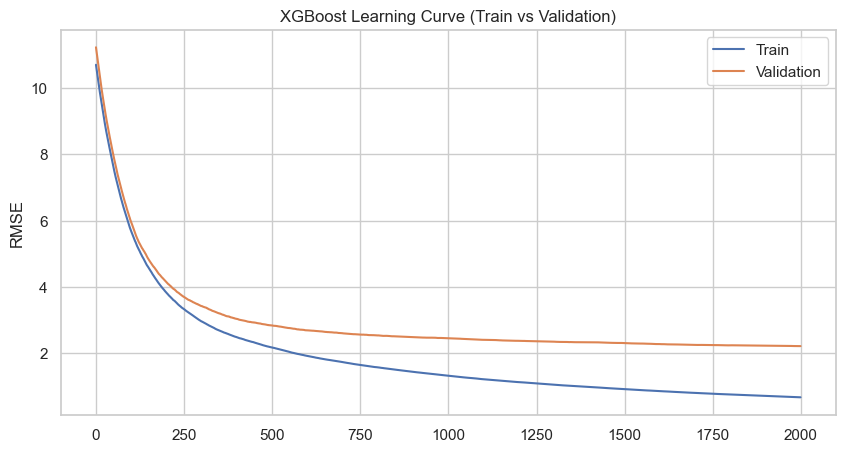

Model berhasil disimpan ke 'pm10_pipeline_enhanced.pkl'


In [55]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================================================================
# 1. PERSIAPAN DATA (Asumsi variabel 'feature_df', 'features', 'target' sudah ada)
# ==============================================================================
X = feature_df[features]
y = target

robust_params = {
    'n_estimators': 2000,          
    'learning_rate': 0.01,          
    'max_depth': 4,                
    'min_child_weight': 10,    
    'gamma': 0.2,             
    'subsample': 0.7,               
    'colsample_bytree': 0.7,        
    'reg_alpha': 1.0,              
    'reg_lambda': 2.0,            
    'n_jobs': -1,
    'random_state': 42,
    'early_stopping_rounds': 50     
}


tscv = TimeSeriesSplit(n_splits=5)
fold = 1
metrics = {'rmse': [], 'mae': [], 'r2': []}

print("Mulai Training dengan Time Series Cross-Validation...")

for train_idx, val_idx in tscv.split(X):
    # Split data berdasarkan waktu
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Inisialisasi model baru setiap fold
    model_cv = XGBRegressor(**robust_params)

    # Train
    model_cv.fit(
        X_train_cv, y_train_cv,
        eval_set=[(X_train_cv, y_train_cv), (X_val_cv, y_val_cv)],
        verbose=False  # Supaya output tidak penuh
    )

    # Evaluasi
    y_pred_cv = model_cv.predict(X_val_cv)
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['r2'].append(r2)

    print(f"Fold {fold} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    fold += 1

# Tampilkan Rata-rata Performa
print("\n=== Rata-rata Performa Validasi ===")
print(f"Avg RMSE : {np.mean(metrics['rmse']):.4f}")
print(f"Avg MAE  : {np.mean(metrics['mae']):.4f}")
print(f"Avg R2   : {np.mean(metrics['r2']):.4f}")

# ==============================================================================
# 4. TRAINING FINAL (FULL DATA)
# ==============================================================================
# Setelah yakin dengan performa CV, kita latih model akhir dengan hampir seluruh data
print("\nMelatih Model Final untuk Disimpan...")

# Sisihkan sedikit data terakhir (misal 5%) hanya untuk early stopping
split_final = int(len(X) * 0.95)
X_train_final, X_val_final = X.iloc[:split_final], X.iloc[split_final:]
y_train_final, y_val_final = y.iloc[:split_final], y.iloc[split_final:]

final_model = XGBRegressor(**robust_params)
final_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_train_final, y_train_final), (X_val_final, y_val_final)],
    verbose=100
)

# ==============================================================================
# 5. VISUALISASI HASIL & FEATURE IMPORTANCE
# ==============================================================================
# Plot Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(final_model, max_num_features=15, importance_type='weight', title='Top 15 Fitur Paling Berpengaruh')
plt.show()

# Plot Learning Curve (Cek Overfitting Visual)
results = final_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve (Train vs Validation)')
plt.show()

# ==============================================================================
# 6. SIMPAN PIPELINE
# ==============================================================================
pipeline_data = {
    "model": final_model,
    "features": features,
    # Simpan juga lags/rolls jika ada dalam variabel terpisah
    "lags": lags,
    "rolls": rolls
}
joblib.dump(pipeline_data, "pm10_pipeline_enhanced.pkl")
print("Model berhasil disimpan ke 'pm10_pipeline_enhanced.pkl'")


In [56]:
y_pred_cv = final_model.predict(X_val_final)
rmse = np.sqrt(mean_squared_error(y_val_final, y_pred_cv))
mae = mean_absolute_error(y_val_final, y_pred_cv)
r2 = r2_score(y_val_final, y_pred_cv)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


RMSE: 2.2154
MAE: 1.7530
R2: 0.9611


In [57]:
feature_df

,pm10_density,aqi_ispu,hour,dayofweek,month,weekofyear,dayofyear,aqi_lag_1,pm10_lag_1,aqi_lag_2,...,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24,aqi_roll_mean_48,aqi_roll_std_48
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-07 22:00:00,37.199167,28.298024,22,6,12,49,341,32.818968,41.283333,28.553750,...,29.890247,2.539568,36.601567,8.613264,34.790299,6.967093,33.190293,7.266791,33.142351,7.944519
2025-12-07 23:00:00,44.585000,32.140238,23,6,12,49,341,28.298024,37.199167,32.818968,...,31.085743,2.437971,34.246951,7.268303,35.366916,6.363265,33.500285,7.044153,33.259716,7.885800
2025-12-08 00:00:00,33.926667,26.984031,0,0,12,50,342,32.140238,44.585000,28.298024,...,29.140764,2.679417,30.753196,3.345860,34.412996,6.710688,33.669325,6.824652,33.412161,7.685621
2025-12-08 01:00:00,40.480833,32.525287,1,0,12,50,342,26.984031,33.926667,32.140238,...,30.549852,3.094087,30.220050,2.557271,34.152941,6.719026,33.741392,6.802082,33.599224,7.548429
2025-12-08 02:00:00,35.405833,27.301179,2,0,12,50,342,32.525287,40.480833,26.984031,...,28.936832,3.111736,30.011288,2.763329,33.339125,6.922335,33.750348,6.793075,33.681269,7.455636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 11:00:00,67.453333,46.315511,11,4,1,2,9,40.426153,50.614167,58.670280,...,48.470648,9.311042,50.108776,7.507303,39.501983,12.287330,41.764388,11.574656,41.418649,11.031030
2026-01-09 12:00:00,54.466667,42.237293,12,4,1,2,9,46.315511,67.453333,40.426153,...,42.992986,3.016528,49.828285,7.810098,40.679049,11.762418,41.852329,11.569689,41.238359,10.943287
2026-01-09 13:00:00,61.611667,43.173210,13,4,1,2,9,42.237293,54.466667,46.315511,...,43.908672,2.136269,47.670634,7.506941,41.550914,11.502986,42.095400,11.531975,41.149594,10.909190


In [58]:
# evaluasi model untuk data training
train_pred = final_model.predict(X_train_final)
train_rmse = np.sqrt(mean_squared_error(y_train_final, train_pred))
train_mae = mean_absolute_error(y_train_final, train_pred)
train_r2 = r2_score(y_train_final, train_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2: {train_r2:.4f}")

Train RMSE: 0.6727
Train MAE: 0.5192
Train R2: 0.9961


## 4. Recursive Forecasting (48 Hours)

In [59]:
pipeline_data = joblib.load("aqi_pipeline_enhanced.pkl")
model = pipeline_data["model"]
features = pipeline_data["features"]
lags = pipeline_data["lags"]
rolls = pipeline_data["rolls"]

historical_data = df.copy()
max_lookback = max(max(lags), max(rolls)) + 1
current_df = historical_data.tail(max_lookback).copy()

future_predictions = []
future_timestamps = []

last_timestamp = current_df.index[-1]
print(f"\nStarting 48h forecast from {last_timestamp}...")

for i in range(1, 49):
    next_time = last_timestamp + timedelta(hours=i)
    # Buat baris baru dengan density yang sama dan aqi sementara NaN
    next_row = pd.DataFrame({
        "pm10_density": [current_df["pm10_density"].iloc[-1]],
        "aqi_ispu": [np.nan]
    }, index=[next_time])
    temp_df = pd.concat([current_df, next_row])

    df_feat = temp_df.copy()
    df_feat["hour"] = df_feat.index.hour
    df_feat["dayofweek"] = df_feat.index.dayofweek
    df_feat["month"] = df_feat.index.month
    df_feat["weekofyear"] = df_feat.index.isocalendar().week.astype(int)
    df_feat["dayofyear"] = df_feat.index.dayofyear


    for l in lags:
        df_feat[f"aqi_lag_{l}"] = df_feat["aqi_ispu"].shift(l)
        df_feat[f"pm10_lag_{l}"] = df_feat["pm10_density"].shift(l)

    for r in rolls:
        df_feat[f"aqi_roll_mean_{r}"] = df_feat["aqi_ispu"].rolling(r).mean()
        df_feat[f"aqi_roll_std_{r}"] = df_feat["aqi_ispu"].rolling(r).std()

    df_feat = df_feat.dropna()

    X_next = df_feat.iloc[[-1]][features]
    pred_aqi = model.predict(X_next)[0]

    future_predictions.append(pred_aqi)
    future_timestamps.append(next_time)

    temp_df.loc[next_time, "aqi_ispu"] = pred_aqi
    current_df = temp_df

forecast = pd.DataFrame({"timestamp": future_timestamps, "pred_aqi": future_predictions}).set_index("timestamp")
forecast.head()


Starting 48h forecast from 2026-01-09 15:00:00...


C:\Users\user\AppData\Local\Temp\ipykernel_35508\1714586744.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([current_df, next_row])
C:\Users\user\AppData\Local\Temp\ipykernel_35508\1714586744.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([current_df, next_row])
C:\Users\user\AppData\Local\Temp\ipykernel_35508\1714586744.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version,

,pred_aqi
timestamp,
2026-01-09 16:00:00,47.755474
2026-01-09 17:00:00,46.696980
2026-01-09 18:00:00,44.191196
2026-01-09 19:00:00,43.779057
2026-01-09 20:00:00,42.153915


In [60]:
# import uvicorn
# from fastapi import FastAPI
# from pydantic import BaseModel
# import pandas as pd
# import numpy as np
# import joblib
# from datetime import timedelta, datetime

# # Initialize FastAPI app
# app = FastAPI(title="AQI Prediction API")

# # Load the trained model and other necessary data
# try:
#     pipeline_data = joblib.load("aqi_pipeline_enhanced.pkl")
#     model = pipeline_data["model"]
#     features = pipeline_data["features"]
#     lags = pipeline_data["lags"]
#     rolls = pipeline_data["rolls"]
#     print("Model and pipeline data loaded successfully!")
# except Exception as e:
#     print(f"Error loading model or pipeline data: {e}")
#     # Exit or handle error appropriately if model cannot be loaded
#     model = None
#     features = []
#     lags = []
#     rolls = []

# # Store a small chunk of historical data for feature generation during prediction
# # This assumes `df` (the original processed dataframe) is available from earlier cells.
# # We need enough data to compute the required lags and rolling features.
# if 'df' in globals():
#     historical_data_for_api = df.copy()
# else:
#     # Fallback if df is not globally available, for example during direct API run
#     # In a real scenario, you might load a recent chunk of data from a database
#     # For this example, we'll create a dummy if df is not found, but it won't be accurate.
#     print("Warning: 'df' not found, creating dummy historical data. Predictions might be inaccurate.")
#     historical_data_for_api = pd.DataFrame({'pm25_density': [15.0]*50, 'aqi_ispu': [40.0]*50},
#                                           index=pd.date_range(end=datetime.now(), periods=50, freq='H'))

# # Define Input Data Model for FastAPI
# class AQIInput(BaseModel):
#     # For real-time prediction, the API typically receives the *latest* known values
#     # and then uses them to generate the next prediction. Lags/rolls are derived.
#     # For a recursive forecast like this, we'll simulate predicting the next hour
#     # based on the *last known point* from the historical data.
#     # The actual timestamp for which we want prediction will be inferred as next hour.
#     # If the user provides a specific timestamp, we'd adjust accordingly.
#     last_known_timestamp: datetime = datetime.now() - timedelta(hours=1)
#     last_known_pm25_density: float
#     last_known_aqi_ispu: float

# # Helper function to generate features for a single prediction point
# def generate_features_for_prediction(last_known_data: pd.Series, next_time: datetime, all_historical_data: pd.DataFrame, lags, rolls, features_list):
#     # Create a temporary DataFrame including the last known historical data
#     # and the new point to be predicted.
#     # We need enough historical context to compute all lags and rolling features.
#     # The 'all_historical_data' passed here should include sufficient prior data.

#     # Ensure the timestamp of the last known data is in the index for proper feature calculation
#     if not isinstance(last_known_data.name, datetime):
#         # Assuming last_known_data is just values, use its own timestamp as index for the series
#         last_known_data.name = next_time - timedelta(hours=1) # Adjust if needed

#     # Combine the relevant historical data with the new point to feature engineer
#     temp_historical = all_historical_data.loc[all_historical_data.index <= last_known_data.name].tail(max(max(lags), max(rolls)) + 1)

#     # Add the last known point if it's not already the very last in temp_historical
#     if temp_historical.empty or temp_historical.index[-1] != last_known_data.name:
#         temp_historical = pd.concat([temp_historical, last_known_data.to_frame().T])

#     # Create a DataFrame for the point to be predicted
#     next_point_df = pd.DataFrame([{'pm25_density': np.nan, 'aqi_ispu': np.nan}], index=[next_time])
#     df_for_feat_eng = pd.concat([temp_historical, next_point_df])

#     # Generate time-based features
#     df_for_feat_eng["hour"] = df_for_feat_eng.index.hour
#     df_for_feat_eng["dayofweek"] = df_for_feat_eng.index.dayofweek
#     df_for_feat_eng["month"] = df_for_feat_eng.index.month
#     df_for_feat_eng["weekofyear"] = df_for_feat_eng.index.isocalendar().week.astype(int)
#     df_for_feat_eng["dayofyear"] = df_for_feat_eng.index.dayofyear

#     # Generate lagged features
#     for l in lags:
#         df_for_feat_eng[f"aqi_lag_{l}"] = df_for_feat_eng["aqi_ispu"].shift(l)
#         df_for_feat_eng[f"pm25_lag_{l}"] = df_for_feat_eng["pm25_density"].shift(l)

#     # Generate rolling features
#     for r in rolls:
#         df_for_feat_eng[f"aqi_roll_mean_{r}"] = df_for_feat_eng["aqi_ispu"].rolling(r).mean()
#         df_for_feat_eng[f"aqi_roll_std_{r}"] = df_for_feat_eng["aqi_ispu"].rolling(r).std()

#     # Extract the features for the *last* row (the one to be predicted)
#     X_next_point = df_for_feat_eng.iloc[[-1]][features_list]

#     return X_next_point


# @app.get("/", summary="Health Check")
# async def root():
#     return {"message": "AQI Prediction API is running!"}


# @app.post("/predict", summary="Predict next AQI (1-hour ahead)")
# async def predict_aqi(input_data: AQIInput):
#     if model is None:
#         return {"error": "Model not loaded. Please check API startup logs."}

#     # Construct the last known data point as a pandas Series
#     last_known_data = pd.Series({
#         'pm25_density': input_data.last_known_pm25_density,
#         'aqi_ispu': input_data.last_known_aqi_ispu
#     }, name=input_data.last_known_timestamp)

#     # The timestamp for which we want to predict is 1 hour after the last known data
#     prediction_timestamp = input_data.last_known_timestamp + timedelta(hours=1)

#     # Generate features for prediction
#     X_predict = generate_features_for_prediction(last_known_data,
#                                                  prediction_timestamp,
#                                                  historical_data_for_api,
#                                                  lags, rolls, features)

#     # Make prediction
#     predicted_aqi = model.predict(X_predict)[0]

#     return {
#         "prediction_timestamp": prediction_timestamp.isoformat(),
#         "predicted_aqi_ispu": float(predicted_aqi)
#     }

## 5. Visualization

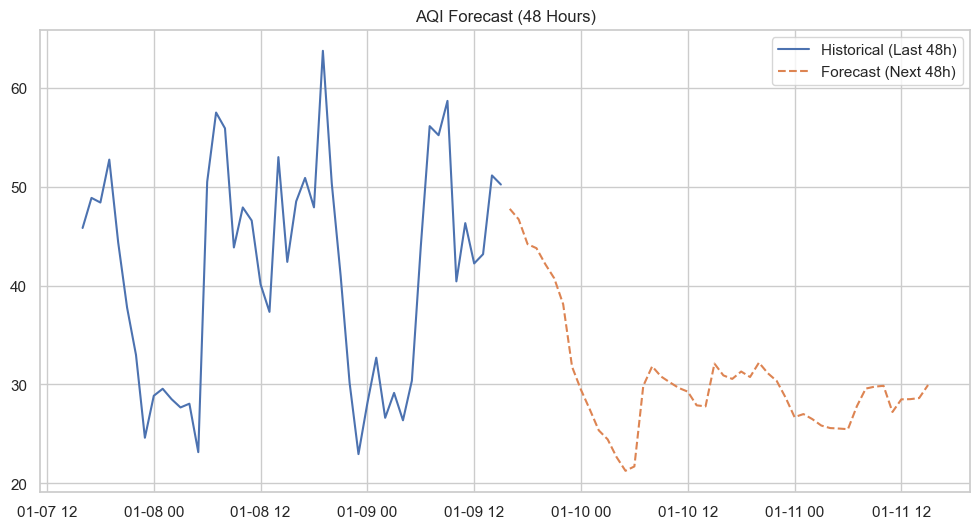

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-48:], df['aqi_ispu'].tail(48), label='Historical (Last 48h)')
plt.plot(forecast.index, forecast['pred_aqi'], label='Forecast (Next 48h)', linestyle='--')
plt.title("AQI Forecast (48 Hours)")
plt.legend()
plt.show()